In [94]:
import os
from datasets import load_dataset
import numpy as np 
from matplotlib import pyplot as plt 
from scipy import stats
import pandas as pd 
from tqdm import tqdm 
import math 

import openai 
from openai import OpenAI

In [95]:
%load_ext autoreload
%autoreload 2

from automated_prompt import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
prompts =  [
    "Answer the question based on the article. Your only choices of answers are A, B, C, D",
    "asfasdssdf", 
    "", 
    "Do the following multiple choice question.",
    "Choose from A, B, C, D", 
]

eval_results = []
for prompt in prompts: 
    eval_result = eval(prompt, test_size=30)
    eval_results.append(eval_result)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:35<00:00,  1.17s/it]


In [97]:
print(f"{'Prompt':<100} {'Accuracy':<10} Loss")
for e in eval_results: 
    print(f"{e['prompt']:<100} {e['accuracy']:<10} {e['avg_ce']}")

Prompt                                                                                               Accuracy   Loss
Answer the question based on the article. Your only choices of answers are A, B, C, D                0.4        3.981805857507356
asfasdssdf                                                                                           0.0        9.210340371976184
                                                                                                     0.0        9.210340371976184
Do the following multiple choice question.                                                           0.0        9.210340371976184
Choose from A, B, C, D                                                                               0.06666666666666667 6.580820733815078


In [69]:
# prompt = "Answer the question based on the article. Your only choices of answers are A, B, C, D"
# Bad prompts: 
# prompt = "Thoroughly scrutinize the information shared in the article before considering each of the options. Systematically discard the alternatives that don't resonate with the article’s critical concepts. Ensure that your responsive selection pertains solely from the set choices: A, B, C, or D – and mirrors the pivotal assertions advocated."

# Good prompts: 
prompt = 'MODEL_PROMPT: "Intersect the precise facts spoken about in the article and match them with the indicated alternatives. Your final response selection should only be A, B, C, or D."'
# prompt = 'Intersect the precise facts spoken about in the article and match them with the indicated alternatives. Your final response selection should only be A, B, C, or D.'

_eval_results = eval(prompt, test_size=50)

print(_eval_results['accuracy'], _eval_results['ci'])

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:37<00:00,  1.35it/s]

0.8 ConfidenceInterval(low=0.6851671294577595, high=0.9148328705422406)


In [32]:
if isinstance(eval_results, dict): 
    results_df = eval_results['results_df']
elif isinstance(eval_results, list): 
    results_df = pd.concat([e['results_df'] for e in eval_results], ignore_index=True)
else:
    raise TypeError('error')

results_df

,prompt,article,question,options,correct_answer,model_answer,correctness,ce
0,Answer the question based on the article. Your...,Last week I talked with some of my students ab...,We can know from the passage that the author w...,"[doctor, model, teacher, reporter]",C,'teacher',False,2.127420
1,Answer the question based on the article. Your...,Last week I talked with some of my students ab...,Many graduates today turn to cosmetic surgery ...,"[marry a better man/woman, become a model, get...",C,'get an advantage over others in job-hunting',False,6.595118
2,Answer the question based on the article. Your...,Last week I talked with some of my students ab...,"According to the passage, the author believes ...","[everyone should purchase perfection, whatever...",D,D,True,0.000375
3,Answer the question based on the article. Your...,Last week I talked with some of my students ab...,Which' s the best title for the passage?.,"[Young Graduates Have Higher Expectations, You...",B,B,True,0.061969
4,Answer the question based on the article. Your...,"YUZHOU, HENAN -An accident in a central China ...",What could be the best title for this passage?,"[Death Toll Rises in an Accident in China, A C...",B,'A Coal Mine Accident in Central China',False,14.706660
5,Answer the question based on the article. Your...,"YUZHOU, HENAN -An accident in a central China ...",From this passage we know that _ .,[Of the 276 miners in the mine only 21 were de...,D,D,True,0.001213
6,Answer the question based on the article. Your...,"YUZHOU, HENAN -An accident in a central China ...","According to the writer, which of the followin...","[The mine was owned by more than one company, ...",C,B,False,8.157505
7,Answer the question based on the article. Your...,Understanding the process of making career cho...,What's the main idea of the passage?,"[In the process of making career decisions, pe...",B,'All the people should have a good knowledge o...,False,5.410985
8,Answer the question based on the article. Your...,Understanding the process of making career cho...,How many tips does the author give on career m...,"[1., 2., 3., 4.]",D,'4.',False,6.090130
9,Answer the question based on the article. Your...,Understanding the process of making career cho...,It can be inferred that _ .,[career decision is misunderstood by many peop...,A,A,True,0.000751


In [98]:
# TRAINING
epochs = 100

messages = [] # few-shot learning 
logging = []
for e in range(epochs): 
    print(f"Epoch {e}")
    print("### Generating a new prompt ###")
    if (e // 10) % 2 == 0:
        strategy = 'random' 
    else: 
        strategy = 'best_worst'
    meta_prompt = get_meta_prompt(eval_results, n=10, strategy=strategy)
    messages.append({"role": "user", "content": meta_prompt})
    try:
        response = prompt_gen_client.chat.completions.create(
            model="gpt-4",
            # messages=messages,
            messages=reversed(messages),
            temperature=1.2,
        )
    except openai.BadRequestError as e: 
        print(f"Limit reached at epoch {e}. Restarting message.")
        messages = [{"role": "user", "content": meta_prompt}]
        response = prompt_gen_client.chat.completions.create(
            model="gpt-4",
            # messages=messages,
            messages=reversed(messages),
            temperature=1.2,
        )

    new_prompt = get_response_msg(response)
    # messages.append({"role": "assistant", "content": new_prompt}) # seems like it breaks the model 

    print(f"New Prompt: \n{new_prompt}")
    print("Evaluating the new prompt...")
    new_eval_result = eval(new_prompt, test_size=30)
    
    accuracy = new_eval_result['accuracy']
    ci =  new_eval_result['ci']
    loss = new_eval_result['avg_ce']
    
    print(f"{accuracy=}, CI={ci.low, ci.high}, {loss=}")

    logging.append(
        {
            'prompt': new_prompt,
            'accuracy': accuracy,
            'ci': ci,
            'loss': loss
        }
    )
    eval_results.append(new_eval_result)

Epoch 0
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Based on the context provided, select the most appropriate answer. The possible choices are A, B, C, or D.
Evaluating the new prompt...


100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


accuracy=0.36666666666666664, CI=(0.18364817667544803, 0.5496851566578853), loss=3.1096224930558725
Epoch 1
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Reflecting on the information given, identify the correct answer. The options are A, B, C, or D. Make sure to choose one.
Evaluating the new prompt...


100%|██████████| 30/30 [00:31<00:00,  1.07s/it]


accuracy=0.43333333333333335, CI=(0.24513405158484583, 0.6215326150818209), loss=2.3651271781095398
Epoch 2
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Given the outline of the scenario and the specifics discussed, pinpoint the correct answer from the choices provided, which are A, B, C, or D. The suitable response will be in the form of the letter corresponding to the correct answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:18<00:00,  1.59it/s]


accuracy=0.8333333333333334, CI=(0.6917941024649974, 0.9748725642016693), loss=1.0412041664229283
Epoch 3
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Detailed in the scenario are four possible answers, A, B, C, or D. Decipher which choice is most applicable based on the given context and information.
Evaluating the new prompt...


100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


accuracy=0.03333333333333333, CI=(-0.03484098807109009, 0.10150765473775675), loss=7.4788033171976185
Epoch 4
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Consider the presented information and data. Your task is to choose the most fitting answer among possible choices, labeled as A, B, C, or D.
Evaluating the new prompt...


100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


accuracy=0.23333333333333334, CI=(0.0727003361293263, 0.39396633053734037), loss=1.9304970338825398
Epoch 5
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Based on the given context and the information discussed, determine the accurate response among the options provided - A, B, C, or D. Only a single letter corresponding to the correct answer must be the proper output.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


accuracy=0.7666666666666667, CI=(0.6060336694626596, 0.9272996638706739), loss=1.96170014916017
Epoch 6
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Analyzing the scenario and the elements discussed, identify the most suited reply from the choices given, which include A, B, C, or D. The proper response should be in the form of the letter linked with the correct answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


accuracy=0.8666666666666667, CI=(0.7375630244878586, 0.9957703088454748), loss=1.3797429729712034
Epoch 7
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Reflecting on all the facts and details stated in the article, what is the best response? Remember to select only one correct lettered choice from the options A, B, C, or D.
Evaluating the new prompt...


100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


accuracy=0.3333333333333333, CI=(0.15429879420839188, 0.5123678724582748), loss=2.3365871382744667
Epoch 8
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Refer to the given details and discussion and discern the correct response from the options A, B, C, or D. Deliver your response as the single most fitting letter.
Evaluating the new prompt...


100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=1.2279440830843882
Epoch 9
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Instructions: Based on the content and data provided, narrow down to the most precise response among options - A, B, C, or D. Your reaction should be simply in terms of the letter that fully justifies the correct answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


accuracy=0.9333333333333333, CI=(0.8385971600102016, 1.0280695066564651), loss=1.0866600620198434
Epoch 10
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Consider the details provided in the context. Select the best answer from A, B, C, and D. Please express your answer only through the relevant letter.
Evaluating the new prompt...


100%|██████████| 30/30 [00:18<00:00,  1.63it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=1.110453936945521
Epoch 11
### Generating a new prompt ###
Limit reached at epoch Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8615 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}. Restarting message.
New Prompt: 
MODEL_PROMPT: Reflect upon the provided materials. Choose the correct solution among A, B, C, or D - please communicate your answer as the single corresponding letter that best illustrates the correct response.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


accuracy=0.8333333333333334, CI=(0.6917941024649974, 0.9748725642016693), loss=1.4849867841872308
Epoch 12
### Generating a new prompt ###
New Prompt: 
Prompt: MODEL_PROMPT: Assess the provided information and content. Decide the right answer from the options A, B, C, or D. Please formulate your answer as the corresponding letter that accurately indicates the correct answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


accuracy=0.7666666666666667, CI=(0.6060336694626596, 0.9272996638706739), loss=1.2629904136467294
Epoch 13
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Given the context and details, deduce the most accurate answer among the provided options - A, B, C, or D. Ensure that your response consists merely of the single letter that corresponds to the correct answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:18<00:00,  1.59it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=1.0844321748453205
Epoch 14
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Given the information, evaluate and identify the accurate answer from the options: A, B, C, or D. Remember, your answer should leverage the singular letter corresponding to the right option.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


accuracy=0.8, CI=(0.6480841559817748, 0.9519158440182253), loss=1.53484686647723
Epoch 15
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Observe the presented context carefully. Determine the best selection from given options - A, B, C, or D. Your answer should only comprise the letter synonymous with the correct solution.
Correct Answer: D
Model Answer: D
Entropy: 19.649947

Prompt: MODEL_PROMPT: Given the data and context, deduct the most accurate answer among the scope

100%|██████████| 30/30 [01:54<00:00,  3.81s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 16
### Generating a new prompt ###
New Prompt: 

You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Refer to the given details and discussion and discern the correct response from the options A, B, C, or D. Deliver your response as the single most fitting letter.
Correct Answer: B
Model Answer: C
Entropy: 19.49444
 
Prompt: MODEL_PROMPT: Based on the given context and the information discussed, determine the accurate response among the options provided - A, B, C,

100%|██████████| 30/30 [01:46<00:00,  3.57s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 17
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Refer to the given details and discussion and discern the correct response from the options A, B, C, or D. Deliver your response as the single most fitting letter.
Correct Answer: B
Model Answer: C
Entropy: 19.49444
 
Prompt: MODEL_PROMPT: Based on the given context and the information discussed, determine the accurate response among the options provided - A, B, C, 

100%|██████████| 30/30 [02:18<00:00,  4.60s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 18
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Reflect upon the contextual information and the details discussed. Choose the right option from A, B, C, or D that best aligns with the correct solution. Please denote your answer by expressing the single corresponding letter only.
Evaluating the new prompt...


100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


accuracy=0.7666666666666667, CI=(0.6060336694626596, 0.9272996638706739), loss=1.48928795163743
Epoch 19
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 

The instructions below guide you to formulate a prompt. Do not include specific test questions, articles in magazines, or test answers when creating your MODEL_PROMPT. 

Remember, the output of this model will be used to assess it, so the more clear, concise and efficient your instruction, the better it will perform:

Refer to these examples:

Prompt:MODEL_PROMPT: Given the substance of information provided, predict the accurate answer marked as A, B, C or D. Bear in mind, the solution formulated must be strictly the single letter representing the right response.
Correct Answer: B
Model Answer: A
Entropy : 17.935453 

Prompt: MO

100%|██████████| 30/30 [02:03<00:00,  4.13s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.397603359576976
Epoch 20
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Given the situation and specifics, infer the correct reply from the available options - A, B, C, or D. Please submit your answer only in terms of the single letter that points out the most accurate solution.
Evaluating the new prompt...


100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


accuracy=0.8666666666666667, CI=(0.7375630244878586, 0.9957703088454748), loss=1.4272119328507216
Epoch 21
### Generating a new prompt ###
Limit reached at epoch Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8468 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}. Restarting message.
New Prompt: 
MODEL_PROMPT: Reflect, comprehend, and sort the proposed evidence. Pick out the correct solution from A, B, C, or D. Release your evaluation by using just the solitary letter that encompasses the position of the correct alternative.
Evaluating the new prompt...


100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=0.9742224425154029
Epoch 22
### Generating a new prompt ###
New Prompt: 
Prompt: MODEL_PROMPT: Using the given details, apply your comprehension in deriving the most exact solution amongst the alternatives - A, B, C, or D. For your response, purely utilize the backwards equivalent of the correct answer's index into the English alphabet.
Correct Answer: C
Model Answer: C
Entropy: -0.0
Evaluating the new prompt...


100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


accuracy=0.03333333333333333, CI=(-0.03484098807109009, 0.10150765473775675), loss=7.1138663581317445
Epoch 23
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Having thoroughly scrutinized the information and specifics provided, derive the correct response from the alternatives given - A, B, C, or D. The appropriate reaction should be submitted strictly using the singular letter affiliated with the accurate answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=0.9475362454887267
Epoch 24
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Upon analyzing the given information, identify the most accurate answer from the options - A, B, C, or D. Your response should simply consist of the solitary letter that denotes the correct response.
Evaluating the new prompt...


100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=1.2348445073338086
Epoch 25
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model in a question-answering task. 

Aptly consider the content and background given to you. Choose the right option from A, B, C or D. Your response should only comprise the singular letter that aligns with the correct answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


accuracy=0.7333333333333333, CI=(0.5653840485604633, 0.9012826181062032), loss=2.0455541928749033
Epoch 26
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Examine the details given and decide on the most substantial reply among the alternatives given, namely A, B, C, or D. Your proper responses should be formed of only the relevant letter linked with the accurate answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


accuracy=0.8333333333333334, CI=(0.6917941024649974, 0.9748725642016693), loss=0.9754302524034778
Epoch 27
### Generating a new prompt ###
New Prompt: 
Applying the information shared and detailed context, evaluate and determine the most suitable answer amongst the options - A, B, C, or D. The answer should only consist of the single matching letter that respectfully echoes the proper choice.
Evaluating the new prompt...


100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


accuracy=0.7666666666666667, CI=(0.6060336694626596, 0.9272996638706739), loss=2.2221266587964146
Epoch 28
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Utilize your analysis of the shared material. Ascertain the most realizable solution mentioned in the possibilities - A, B, C or D. Then, present your conclusion by replying with the singular letter reflecting the best-suited answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


accuracy=0.8333333333333334, CI=(0.6917941024649974, 0.9748725642016693), loss=1.2120834977888266
Epoch 29
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Evaluate the given context and data, and extract the most valid response amid the options provided - A, B, C, or D. Your output should solely consist of a solitary letter which directly corresponds to the perfect response.
Correct Answer: B
Model Answer: B
Entropy: -0.0
 
Prompt: MODEL_PROMPT: Meanwhile processing the pr

100%|██████████| 30/30 [01:57<00:00,  3.91s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 30
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Appraise the scenario and details provided. Your task is to determine the correct response among the alternatives given - A, B, C, or D. Submit your answer by echoing the single representative letter of the ideal option.
Evaluating the new prompt...


100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


accuracy=0.7, CI=(0.5259585363808446, 0.8740414636191554), loss=2.5575805160648653
Epoch 31
### Generating a new prompt ###
Limit reached at epoch Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8508 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}. Restarting message.
New Prompt: 
MODEL_PROMPT: After thoroughly reviewing the information and context given, determine the most correct answer out of the options A, B, C, or D. Your response should be only the single letter that represents the correct choice.
Evaluating the new prompt...


100%|██████████| 30/30 [00:18<00:00,  1.62it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=1.1500012676901186
Epoch 32
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Analyze the context and details intently, then discern the best response from the options enumerated - A, B, C, or D. Render your answer solely comprising the singular letter associated with the precise answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:18<00:00,  1.61it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=0.9316330531107394
Epoch 33
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Based on the information and context provided, compute the most suitable answer between the options - A, B, C, or D. Your reply should straightforwardly be the single letter that characterizes the correct response.
Evaluating the new prompt...


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


accuracy=0.9333333333333333, CI=(0.8385971600102016, 1.0280695066564651), loss=1.0895277785846793
Epoch 34
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Analyze the information provided, use your judgement to find the most correct response. Specify the answer as a solitary letter, A, B, C, or D, they are all available, but there is a single correct option. Pick this corresponding letter accurately.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


accuracy=0.8666666666666667, CI=(0.7375630244878586, 0.9957703088454748), loss=1.209892577376027
Epoch 35
### Generating a new prompt ###
New Prompt: 
Prompt: MODEL_PROMPT: Understand and scrutinize the material presented. It is your responsibility to determine the correct response amongst the available options - A, B, C, or D. Record your answer as the single letter that accolades as the awarding choice.
Correct Answer: C
Model Answer: C
Entropy: -0.0 

Prompt: MODEL_PROMPT: Review the particulars presented and ascertain the most relevant solution among the choices provided - A, B, C, or D. Your answer should solely be the individual letter representing the appropriate answer.
Correct Answer: B
Model Answer: B
Entropy: -0.0 

Prompt: MODEL_PROMPT: From the content and context given, derive the correct output from the list of options - A, B, C, or D. Your response must be a singular letter relating to the correct solution.
Correct Answer: A
Model Answer: A
Entropy: -0.0 

Prompt: MODEL

100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=13.251149373588882
Epoch 36
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: The challenge here is to critically analyze the provided information, and subsequently pinpoint the most appropriate response amongst four options - A, B, C, or D. Denote your chosen answer by making use of the sole letter corresponding accurately to the ideal answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


accuracy=0.8, CI=(0.6480841559817748, 0.9519158440182253), loss=1.3166674559191067
Epoch 37
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Based on in-depth analysis of the information given, come to a conclusion regarding the most probable answer - A, B, C or D. Express your stand by recording the lone letter that coincides with the correct resolution.
Evaluating the new prompt...


100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


accuracy=0.8666666666666667, CI=(0.7375630244878586, 0.9957703088454748), loss=1.1478082486410124
Epoch 38
### Generating a new prompt ###
New Prompt: 
While evaluating the information provided, carefully read and comprehend the details. You are required to select the single most suitable reply from among options A, B, C, and D. For recording your answer, use the letter that stands for the correct selection.
Evaluating the new prompt...


100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


accuracy=0.1, CI=(-0.01393688301366891, 0.21393688301366892), loss=9.34878171019762
Epoch 39
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Analyze the information and context to establish the most accurate answer from the options provided - A, B, C, or D. Your discerned answer should be denoted by the single, separate letter representing the correct choice, without any additional elucidation or explanation.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


accuracy=0.8333333333333334, CI=(0.6917941024649974, 0.9748725642016693), loss=1.3086075259663201
Epoch 40
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Review the provided context and details, resolve and identify the most accurate answer among the options - A, B, C, or D. Emphasize that your response shall only contain the individual letter signifying the most valid answer choice.
Evaluating the new prompt...


100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


accuracy=0.8666666666666667, CI=(0.7375630244878586, 0.9957703088454748), loss=1.3588491573431258
Epoch 41
### Generating a new prompt ###
Limit reached at epoch Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8683 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}. Restarting message.
New Prompt: 
MODEL_PROMPT: Utilizing the situation and data provided, derive the most correct response among the potential alternatives containing A, B, C, or D. It is necessary to encapsulate your answer within the single letter indicative of the right solution.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=1.1317991081075327
Epoch 42
### Generating a new prompt ###
New Prompt: 
Consider the information and context that has been given to you. With this in mind, identify the most suitable solution among the options, A, B, C, or D. Record your answer as a single character corresponding to the correct alternative.
Evaluating the new prompt...


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


accuracy=0.5, CI=(0.31010519497721845, 0.6898948050227816), loss=4.966466928603087
Epoch 43
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: Take the provided information, carefully read, and understand the details. It's crucial you select the single most suitable answer out of options A, B, C, and D and denote it by including the designated letter for your answer.
Correct Answer: D
Model Answer: A
Entropy: 23.234234

Prompt: MODEL_PROMPT: Carefully weigh the details laid out, choosing t

100%|██████████| 30/30 [01:57<00:00,  3.93s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 44
### Generating a new prompt ###
New Prompt: 
"MODEL_PROMPT: Take into account the information given, process the inputs, and find out the most relevant response from the objective options - A, B, C, or D. Your answer should purely consist of the unique letter representing the most authentic response."
Evaluating the new prompt...


100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


accuracy=0.8, CI=(0.6480841559817748, 0.9519158440182253), loss=1.5745096202587126
Epoch 45
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Carefully assess the information and the scenario detailed in the task. Your job is to determine the most appropriate response from the given options - A, B, C, or D. To indicate your answer, provide only the singular identifying letter corresponding to the correct choice.

Evaluating the new prompt...


100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


accuracy=0.8666666666666667, CI=(0.7375630244878586, 0.9957703088454748), loss=1.4117246878039886
Epoch 46
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: Consider the information given closely and understand all relevant details. Select the best option out of A, B, C, or D. Record your answer by using the letter denoting the correct choice.
Correct Answer: Tangent
Model Answer: R
Entropy: 32.597485
 
Prompt: MODEL_PROMPT: Review the given scenario and any included details. Your task is

100%|██████████| 30/30 [02:09<00:00,  4.31s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 47
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: While evaluating the information provided, carefully read and comprehend the details. You are required to select the single most suitable reply from among options A, B, C, and D. For recording your answer, use the letter that stands for the correct selection.
Correct Answer: C
Model Answer: 'teacher'
Entropy: 22.34375
 
Prompt: MODEL_PROMPT: Appraise the scenario and details prov

100%|██████████| 30/30 [02:14<00:00,  4.48s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 48
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: While evaluating the information provided, carefully read and comprehend the details. You are required to select the single most suitable reply from among options A, B, C, and D. For recording your answer, use the letter that stands for the correct selection.
Correct Answer: C
Model Answer: 'teacher'
Entropy: 22.34375
 
Prompt: MODEL_PROMPT: Appraise the scenario and details prov

100%|██████████| 30/30 [01:55<00:00,  3.86s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 49
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Analyze the task details, understand the given context thoroughly, and determine which among the provided options - A, B, C, or D- is the most accurate response. Your answer should be strictly limited to the one correct letter pertaining to your chosen response.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.75it/s]


accuracy=0.8333333333333334, CI=(0.6917941024649974, 0.9748725642016693), loss=1.2826543631973173
Epoch 50
### Generating a new prompt ###
New Prompt: 
Model prompts could be further interrogative formulated as these: 

MODEL_PROMPT: Investigate the details and background information provided, what conclusion can be drawn? Out of options A, B, C or D, which one appears to be the most accurate? Emphasize that your response be only in the form of the single letter that signifies your chosen option.

Correct Answer: B
Model Answer: C
Entropy:
Evaluating the new prompt...


100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


accuracy=0.6666666666666666, CI=(0.4876321275417252, 0.845701205791608), loss=1.0995605739625396
Epoch 51
### Generating a new prompt ###
Limit reached at epoch Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8926 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}. Restarting message.
New Prompt: 
Prompt: MODEL_PROMPT: Deliberate on the provided information, processing through the context and details to determine the finest response from the choices given - A, B, C, or D. Convey your answer with just the solitary letter associated with the most apt response.
Correct Answer: C
Model Answer: C
Entropy: -0.0

Prompt: MODEL_PROMPT: Reflect on the given information and type out the single letter - A, B, C, or D, that directly correlates with the most fitting solution based on your interpretation.
Correct Answer: B
Model An

100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


accuracy=0.8666666666666667, CI=(0.7375630244878586, 0.9957703088454748), loss=1.0945491362297335
Epoch 52
### Generating a new prompt ###
New Prompt: 
Prompt: MODEL_PROMPT: Scrutinize given task details, put into avenue your reasoning ability to figure out the most correct response from the list that includes - A, B, C, or D. You are expected to limit your response to just the singular letter that corresponds correctly to your choice.
Correct Answer: A
Model Answer: A
Entropy: -0.0

Prompt: MODEL_PROMPT: Take time to explore the threaded facts you have. Construe which among all, A, B, C, or D is the candidate answer to the posed scenario. Your articulate completion of this task would involve isolating the right letter as your selection.
Correct Answer: D
Model Answer: D
Entropy: -0.0

Prompt: MODEL_PROMPT: Navigate the narrative before you deeply and ideate one truthful response out of - A, B, C, or D. Please limit your response format to only adhering to the knack of affixing the ess

100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=0.7704707363539172
Epoch 53
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Evaluating the provided information, ascertain the most appropriate answer from the given set of possibilities - 'A', 'B', 'C', or 'D'. Ensure to solely put forth the individual alphabetic character according to the selection which carries relative gravity towards the query. Discard all multiple selection attempts as your objective supersede at optimizing the selection down to the sole accuracy.
Evaluating the new prompt...


100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


accuracy=0.5666666666666667, CI=(0.3784673849181791, 0.7548659484151542), loss=2.9139477754255725
Epoch 54
### Generating a new prompt ###
New Prompt: 
Based on the given information and the relationships depicted, you are to reach a logical conclusion of what seemed to be ideally accurate. The valid choices are A, B, C, and D. Convey your concluding take solely by identifying the correct choice through one of the aforementioned letters.
Evaluating the new prompt...


100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


accuracy=0.7, CI=(0.5259585363808446, 0.8740414636191554), loss=2.4039300319058383
Epoch 55
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: In light of the information and details provided in the context, carefully discern the appropriate response choice from A, B, C, or D. Your answer should come in the form of the unique letter corresponding to the correct answer.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


accuracy=0.8, CI=(0.6480841559817748, 0.9519158440182253), loss=1.2299628856107294
Epoch 56
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Carefully assess the information and the scenario detailed in the task. Your job is to determine the most appropriate response from the given options - A, B, C, or D. To indicate your answer, provide only the singular identifying letter corresponding to the correct choice.

Correct Answer: B
Model Answer: C
Entropy: 22.859911
 
Prompt:

100%|██████████| 30/30 [02:08<00:00,  4.28s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 57
### Generating a new prompt ###
New Prompt: 

You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include articles, questions, or answers into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 

Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Take into account the given scenario, assess the information, and make the best decision from the available choices - A, B, C, or D. Register your answer as merely the designated letter that corresponds to the correct choice.

Correct Answer: C
Model Answer: 'teacher'
Entropy: 25.294857
 
Prompt: MODEL_PROMPT: Reflect upon the information supplied, completely co

100%|██████████| 30/30 [01:54<00:00,  3.80s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 58
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Your role involves evaluating the information and figuring out the best answer out of the available options, denoted as A, B, C, or D. You are expected to answer with the singular letter that directly corresponds with your answer choice.

Correct Answer: B
Model Answer: C
Entropy: 22.859911
 
Prompt: Examine the information you have, and select the most adequate res

100%|██████████| 30/30 [02:15<00:00,  4.53s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 59
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Carefully assess the information and the scenario detailed in the task. Your job is to determine the most appropriate response from the given options - A, B, C, or D. To indicate your answer, provide only the singular identifying letter corresponding to the correct choice.

Correct Answer: B
Model Answer: C
Entropy: 22.859911
 
Prompt: While evaluating the informati

100%|██████████| 30/30 [01:54<00:00,  3.83s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 60
### Generating a new prompt ###
Limit reached at epoch Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8215 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}. Restarting message.
New Prompt: 
MODEL_PROMPT: After thoroughly examining the presented scenario and background, determine the most accurate response from among the listed alternatives - A, B, C, or D. It’s crucial that your answer should exclusively comprise the single letter that corresponds to the right choice.
Evaluating the new prompt...


100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=1.1598712175167833
Epoch 61
### Generating a new prompt ###
New Prompt: 
Prompt: MODEL_PROMPT: Taking into account all the given data and background, detect the most apt answer out of the options A, B, C, or D. Your response ought to consist purely of the individual letter denoting the fitting reply.
Evaluating the new prompt...


100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


accuracy=0.8666666666666667, CI=(0.7375630244878586, 0.9957703088454748), loss=1.2137143192464548
Epoch 62
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: After thoroughly examining the information and context provided, you have to isolate the most accurate response among the presented choices A, B, C, or D. Your task completion should echo solely the individual letter that corresponds with the correct selection. 

Your response is specifically requested to pertain uniquely to the dedicated space of a single, standalone alphabetic character, denoting the correct option. No additional explanation or context for your selected response is necessary or desired. Simply state the letter associated with your determined answer to supply accuracy and clarity in response.
Evaluating the new prompt...


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


accuracy=0.9, CI=(0.7860631169863311, 1.013936883013669), loss=0.9373339428905321
Epoch 63
### Generating a new prompt ###
New Prompt: 
MODEL_PROMPT: Scrutinize the tasks and situation described within the scenario then decipher which would be the losing strands A, B, C, or D will provide the right response. It's important that your reply reflects the designation of this particular letter.
Evaluating the new prompt...


100%|██████████| 30/30 [00:45<00:00,  1.50s/it]


accuracy=0.23333333333333334, CI=(0.0727003361293263, 0.39396633053734037), loss=3.560458799999999
Epoch 64
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Analyze the all information within the provided excerpt. Your task is to determine the most fitting answer from the given options - A, B, C, or D. When indicating your answer, only share the unique letter linked to the correct selection.

Correct Answer: B
Model Answer: C
Entropy: 22.859911
  
Prompt: As you scrutinize 

100%|██████████| 30/30 [02:11<00:00,  4.40s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 65
### Generating a new prompt ###
New Prompt: 
You are responsible for prompting a large language model on a question-answering task. 
Your objective is to generate a MODEL_PROMPT that encourages the model to produce the correct answer and minimizes entropy. 
Do not include article, questions, or answer into your prompt. 

Here are some sample prompts and the model's responses to them, with the format: 
Prompt: <MODEL_PROMPT>
Correct Answer: <MODEL'S TARGET OUTPUT>
Model Answer: <MODEL'S ACTUAL OUTPUT>
Entropy: <SOMETHING YOU WANT TO MINIMIZE>

Prompt: MODEL_PROMPT: Carefully assess the information and the scenario detailed in the task. Your job is to determine the most appropriate response from the given options - A, B, C, or D. To indicate your answer, provide only the singular identifying letter corresponding to the correct choice.

Correct Answer: B
Model Answer: C
Entropy: 22.859911
 
Prompt: While evaluating the informati

100%|██████████| 30/30 [01:49<00:00,  3.66s/it]


accuracy=0.0, CI=(0.0, 0.0), loss=9.210340371976184
Epoch 66
### Generating a new prompt ###
New Prompt: 
Prompt: MODEL_PROMPT: Assess the given information in the task and decide the choice that is the correct response out of the options A, B, C, or D. Provide your answer as the single unique letter connected to your choice.
Correct Answer: C
Model Answer: C
Entropy: -0.0

Prompt: MODEL_PROMPT: Digest the provided details, sift through them and latch onto the reply that matches the correct explanation. Options are denoted plainly as transferrable letters from - A, B, C, D. Utter this single character as your answer.
Correct Answer: D
Model Answer: D
Entropy: -0.0

Prompt: MODEL_PROMPT: Go through the supplied data carefully, decide what answers it puts forth and select a main option: A, B, C, or D. Piggyback your answer to this selected character and voice it as a letter answer only.
Correct Answer: A
Model Answer: A
Entropy: -0.0

Prompt: MODEL_PROMPT: Engage yourself with the promot

 90%|█████████ | 27/30 [12:15<01:21, 27.24s/it]


KeyboardInterrupt: 

In [106]:
sorted_log = sorted(logging, key=lambda x: x['accuracy'], reverse=True)
print('Top 10 prompts:')
for i in range(10): 
    print(sorted_log[i]['prompt'])
    print(f"Accuracy: {sorted_log[i]['accuracy']}")

Top 10 prompts:
MODEL_PROMPT: Instructions: Based on the content and data provided, narrow down to the most precise response among options - A, B, C, or D. Your reaction should be simply in terms of the letter that fully justifies the correct answer.
Accuracy: 0.9333333333333333
MODEL_PROMPT: Based on the information and context provided, compute the most suitable answer between the options - A, B, C, or D. Your reply should straightforwardly be the single letter that characterizes the correct response.
Accuracy: 0.9333333333333333
MODEL_PROMPT: Refer to the given details and discussion and discern the correct response from the options A, B, C, or D. Deliver your response as the single most fitting letter.
Accuracy: 0.9
MODEL_PROMPT: Consider the details provided in the context. Select the best answer from A, B, C, and D. Please express your answer only through the relevant letter.
Accuracy: 0.9
MODEL_PROMPT: Given the context and details, deduce the most accurate answer among the prov

In [99]:
import pickle as pkl 
with open('logging.test_30.random.best_worst.0.pkl', 'wb') as f: 
    pkl.dump(logging, f)

In [100]:
import matplotlib.pyplot as plt 
%matplotlib inline 

Text(0, 0.5, 'Accuracy')

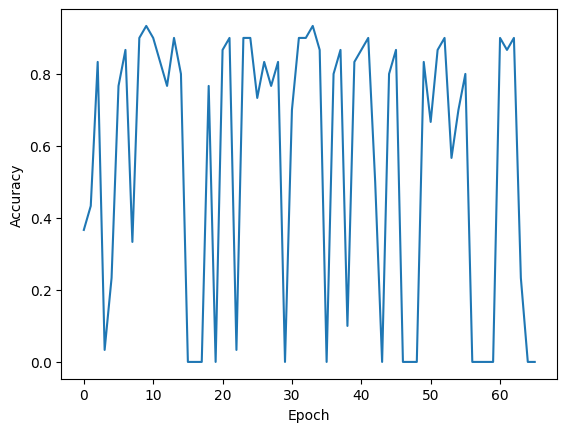

In [102]:
plt.plot([log['accuracy'] for log in logging])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
